In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='AgV_GAivCIPnsXxIkrTsCcvY3CSFIxGQRLs1HL6_ZG-F',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.eu-gb.cloud-object-storage.appdomain.cloud')

bucket = 'intelligentclassificationofrurali-donotdelete-pr-qameogkbejwu8j'
object_key = 'PMGSY_DATASET.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head(10)


,STATE_NAME,DISTRICT_NAME,PMGSY_SCHEME,NO_OF_ROAD_WORK_SANCTIONED,LENGTH_OF_ROAD_WORK_SANCTIONED,NO_OF_BRIDGES_SANCTIONED,COST_OF_WORKS_SANCTIONED,NO_OF_ROAD_WORKS_COMPLETED,LENGTH_OF_ROAD_WORK_COMPLETED,NO_OF_BRIDGES_COMPLETED,EXPENDITURE_OCCURED,NO_OF_ROAD_WORKS_BALANCE,LENGTH_OF_ROAD_WORK_BALANCE,NO_OF_BRIDGES_BALANCE,Unnamed: 14
0,Andaman And Nicobar,Nicobar,PMGSY-I,3,2.969,0,1.38570,3,2.969,0,1.1082,0,0.000,0,NaN
1,Andaman And Nicobar,North and Middle Andaman,PMGSY-I,32,60.169,0,24.69080,32,59.190,0,18.5754,0,0.000,0,NaN
2,Andaman And Nicobar,North and Middle Andaman,PMGSY-II,24,54.670,0,27.76460,0,0.000,0,0.0000,24,54.670,0,NaN
3,Andaman And Nicobar,South Andaman,PMGSY-I,32,40.146,0,18.53750,31,39.287,0,11.6894,1,0.541,0,NaN
4,Andaman And Nicobar,South Andaman,PMGSY-II,24,41.992,0,23.42439,7,17.747,0,8.6343,17,24.033,0,NaN
5,Andhra Pradesh,Anantapur,PMGSY-I,619,2169.505,35,526.12770,619,2126.386,34,517.9120,0,0.000,1,NaN
6,Andhra Pradesh,Anantapur,PMGSY-II,14,125.700,0,56.07110,14,124.619,0,49.0126,0,0.000,0,NaN
7,Andhra Pradesh,Anantapur,PMGSY-III,27,267.158,8,180.52038,24,234.902,0,111.5182,3,23.200,8,NaN
8,Andhra Pradesh,Chittoor,PMGSY-I,283,889.681,6,188.35580,283,878.711,6,185.1493,0,0.000,0,NaN
9,Andhra Pradesh,Chittoor,PMGSY-II,18,126.045,0,57.96680,18,121.403,0,46.1360,0,0.000,0,NaN


In [3]:
#Random Forest Classifier

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [5]:
# Drop rows with essential missing values
df = df.dropna(subset=[
    'PMGSY_SCHEME', 'STATE_NAME', 'DISTRICT_NAME',
    'LENGTH_OF_ROAD_WORK_SANCTIONED', 'NO_OF_ROAD_WORK_SANCTIONED',
    'COST_OF_WORKS_SANCTIONED', 'EXPENDITURE_OCCURED'
])

In [6]:
# Derived features
df['completion_ratio'] = df['LENGTH_OF_ROAD_WORK_COMPLETED'] / df['LENGTH_OF_ROAD_WORK_SANCTIONED']
df['bridge_completion_ratio'] = df['NO_OF_BRIDGES_COMPLETED'] / df['NO_OF_BRIDGES_SANCTIONED'].replace(0, 1)
df['expenditure_efficiency'] = df['EXPENDITURE_OCCURED'] / df['COST_OF_WORKS_SANCTIONED']

In [7]:
features = [
    'STATE_NAME', 'DISTRICT_NAME',
    'LENGTH_OF_ROAD_WORK_SANCTIONED', 'NO_OF_ROAD_WORK_SANCTIONED',
    'NO_OF_BRIDGES_SANCTIONED', 'COST_OF_WORKS_SANCTIONED',
    'NO_OF_ROAD_WORKS_COMPLETED', 'LENGTH_OF_ROAD_WORK_COMPLETED',
    'NO_OF_BRIDGES_COMPLETED', 'EXPENDITURE_OCCURED',
    'NO_OF_ROAD_WORKS_BALANCE', 'LENGTH_OF_ROAD_WORK_BALANCE', 'NO_OF_BRIDGES_BALANCE',
    'completion_ratio', 'bridge_completion_ratio', 'expenditure_efficiency'
]

target = 'PMGSY_SCHEME'

X = df[features]
y = df[target]

In [32]:
# Define categorical and numerical features
categorical_features = ['STATE_NAME', 'DISTRICT_NAME']
numerical_features = list(set(features) - set(categorical_features))

# Build preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features),
    
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ]), numerical_features)
])


In [33]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=150, random_state=42))
])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [35]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['STATE_NAME',
                                                   'DISTRICT_NAME']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['LENGTH_OF_ROAD_WORK_BALANCE',
                                                   'completion_ratio',
                                                   'NO_OF_BRIDGES_SANCTIO...
                                                   'LENGTH_OF_ROAD_WORK_SANCTIONED',
                                                   'bridge_completion_ratio',
                                                   'EXPENDITURE_OCCURED',
                                                   'NO_OF_BRIDGES_COMPLETED',
                                                   'NO_OF_BRIDGES_BALANCE',
                                                   'NO_OF_ROAD_WORKS_BALANCE',
                                                   'NO_OF_ROAD_WORKS_COMPLETED',
                                                   'LENGTH_OF_ROAD_WORK_COMPLETED',
                                                   'NO_OF_ROAD_WORK_SANCTIONED',
                                                   'expenditure_efficiency'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

In [37]:
rf_pred = pipeline.predict(X_test)

print("\nClassification Report (Random Forest Classifier):\n", classification_report(y_test,rf_pred,zero_division=0))
print("Accuracy Score (Random Forest Classifier):", round(accuracy_score(y_test, rf_pred) * 100, 2), "%")


Classification Report (Random Forest Classifier):
               precision    recall  f1-score   support

     PMGSY-I       0.96      0.97      0.97       141
    PMGSY-II       0.88      0.91      0.90       137
   PMGSY-III       0.88      0.91      0.90       139
     RCPLWEA       0.00      0.00      0.00        11

    accuracy                           0.91       428
   macro avg       0.68      0.70      0.69       428
weighted avg       0.89      0.91      0.90       428

Accuracy Score (Random Forest Classifier): 90.89 %


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

#  Encode string labels to numeric
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(rf_pred)

# 🔹 Calculate metrics
mae = mean_absolute_error(y_test_encoded, y_pred_encoded)
mse = mean_squared_error(y_test_encoded, y_pred_encoded)
rmse = np.sqrt(mse)

print("\nMean Absolute Error (MAE) of Random Forest alg:", round(mae, 4))
print("Mean Squared Error (MSE)of Random Forest Alg:", round(mse, 4))
print("Root Mean Squared Error (RMSE) of Random Forest Alg:", round(rmse, 4))



Mean Absolute Error (MAE) of Random Forest alg: 0.0981
Mean Squared Error (MSE)of Random Forest Alg: 0.1121
Root Mean Squared Error (RMSE) of Random Forest Alg: 0.3349


In [15]:
sample_data = pd.DataFrame([{
    'STATE_NAME': 'Tamil Nadu',
    'DISTRICT_NAME': 'Chengalpattu',
    'LENGTH_OF_ROAD_WORK_SANCTIONED': 197,
    'NO_OF_ROAD_WORK_SANCTIONED': 403.113,
    'NO_OF_BRIDGES_SANCTIONED': 0,
    'COST_OF_WORKS_SANCTIONED': 90.8977,
    'NO_OF_ROAD_WORKS_COMPLETED': 197,
    'LENGTH_OF_ROAD_WORK_COMPLETED': 400.157,
    'NO_OF_BRIDGES_COMPLETED': 0,
    'EXPENDITURE_OCCURED': -16.8283,
    'NO_OF_ROAD_WORKS_BALANCE': 0,
    'LENGTH_OF_ROAD_WORK_BALANCE': 0,
    'NO_OF_BRIDGES_BALANCE': 0,
    'completion_ratio': 10.5 / 15.2,
    'bridge_completion_ratio': 1 / 1,
    'expenditure_efficiency': 100.0 / 120.5
}])


#Predict the scheme using the trained pipeline
predicted_scheme = pipeline.predict(sample_data)
print("\n Predicted PMGSY_SCHEME for sample input:", predicted_scheme[0])



 Predicted PMGSY_SCHEME for sample input: PMGSY-I


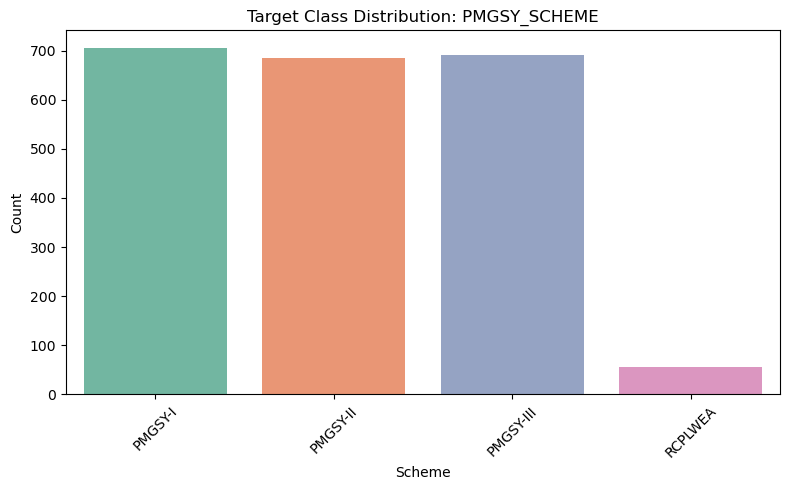

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='PMGSY_SCHEME', palette='Set2')
plt.title("Target Class Distribution: PMGSY_SCHEME")
plt.xlabel("Scheme")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
#GRIDSEARCHCV HYPERPARAMETER TUNING

In [18]:
from sklearn.model_selection import GridSearchCV

#  Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

#  Replace pipeline classifier with a base estimator
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

#  Fit GridSearchCV
grid_search.fit(X_train, y_train)

#  Best parameters & evaluation
print("\n Best Parameters:", grid_search.best_params_)

#  Predict using best estimator
best_model = grid_search.best_estimator_
gs_pred = best_model.predict(X_test)



Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=150; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=150; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__bootstrap=True, classi

In [19]:
print("\nTuned Classification Report:\n", classification_report(y_test, gs_pred))
print("Tuned Accuracy Score:", round(accuracy_score(y_test, gs_pred) * 100, 2), "%")


Tuned Classification Report:
               precision    recall  f1-score   support

     PMGSY-I       0.96      0.97      0.97       141
    PMGSY-II       0.90      0.92      0.91       137
   PMGSY-III       0.89      0.93      0.91       139
     RCPLWEA       1.00      0.09      0.17        11

    accuracy                           0.92       428
   macro avg       0.94      0.73      0.74       428
weighted avg       0.92      0.92      0.91       428

Tuned Accuracy Score: 91.82 %


In [21]:
# Encode y_test and gs_pred to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)
gs_pred_enc = le.transform(gs_pred)

#  Error metrics
mae = mean_absolute_error(y_test_enc, gs_pred_enc)
mse = mean_squared_error(y_test_enc, gs_pred_enc)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE) of Grid SearchCV:", round(mae, 4))
print("Mean Squared Error (MSE) of Grid SearchCV:", round(mse, 4))
print("Root Mean Squared Error (RMSE) of Grid SearchCV:", round(rmse, 4))


Mean Absolute Error (MAE) of Grid SearchCV: 0.0911
Mean Squared Error (MSE) of Grid SearchCV: 0.1098
Root Mean Squared Error (RMSE) of Grid SearchCV: 0.3314


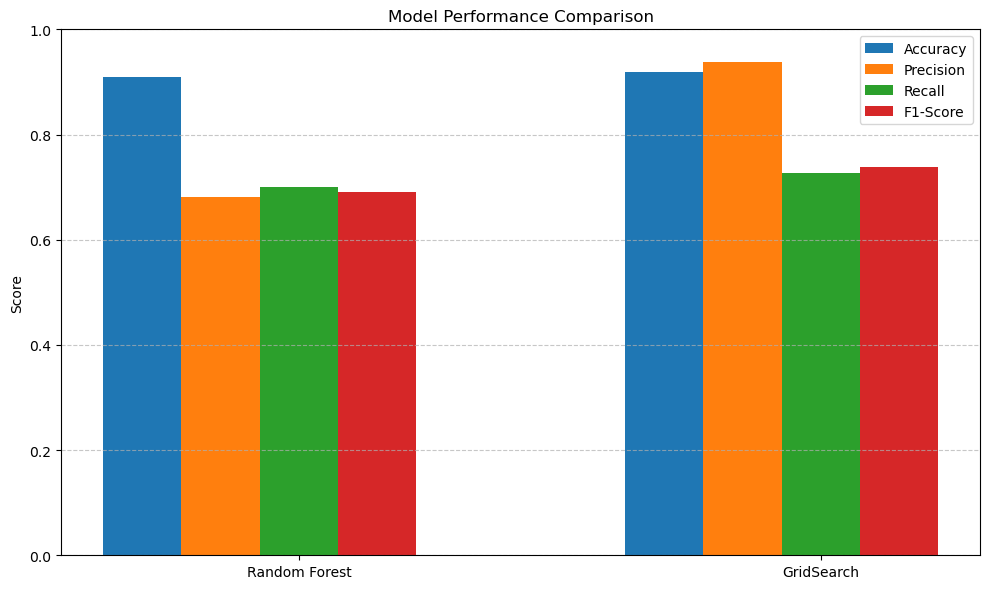

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Calculate metrics
metrics = {
    'Accuracy': [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, gs_pred)
    ],
    'Precision': [
        precision_score(y_test, rf_pred, average='macro', zero_division=0),
        precision_score(y_test, gs_pred, average='macro', zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, rf_pred, average='macro', zero_division=0),
        recall_score(y_test, gs_pred, average='macro', zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, rf_pred, average='macro', zero_division=0),
        f1_score(y_test, gs_pred, average='macro', zero_division=0)
    ],
}

# Plot
labels = ['Random Forest', 'GridSearch']
x = range(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))

for i, (metric, scores) in enumerate(metrics.items()):
    ax.bar([p + 0.15 * i for p in x], scores, width=0.15, label=metric)

ax.set_xticks([p + 0.3 for p in x])
ax.set_xticklabels(labels)
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.legend()
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Sample data
sample_data = pd.DataFrame([{
    'STATE_NAME': 'Tamil Nadu',
    'DISTRICT_NAME': 'Chengalpattu',
    'LENGTH_OF_ROAD_WORK_SANCTIONED': 197,
    'NO_OF_ROAD_WORK_SANCTIONED': 403.113,
    'NO_OF_BRIDGES_SANCTIONED': 0,
    'COST_OF_WORKS_SANCTIONED': 90.8977,
    'NO_OF_ROAD_WORKS_COMPLETED': 197,
    'LENGTH_OF_ROAD_WORK_COMPLETED': 400.157,
    'NO_OF_BRIDGES_COMPLETED': 0,
    'EXPENDITURE_OCCURED': -16.8283,
    'NO_OF_ROAD_WORKS_BALANCE': 0,
    'LENGTH_OF_ROAD_WORK_BALANCE': 0,
    'NO_OF_BRIDGES_BALANCE': 0,
    'completion_ratio': 10.5 / 15.2,
    'bridge_completion_ratio': 1 / 1,
    'expenditure_efficiency': 100.0 / 120.5
}])

#  Use the same features and preprocessing
sample_data = sample_data[features]  # Make sure features are consistent

# Predict using the best model from GridSearchCV
predicted_scheme = grid_search.best_estimator_.predict(sample_data)
print("Predicted PMGSY Scheme:", predicted_scheme)


Predicted PMGSY Scheme: ['PMGSY-I']


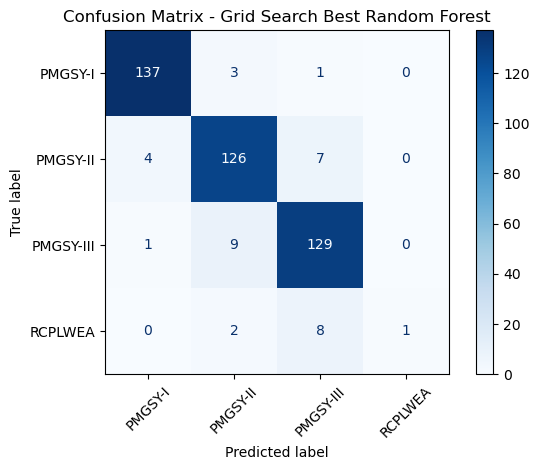

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test)
gs_pred_enc = le.transform(gs_pred)
# Generate confusion matrix
cm = confusion_matrix(y_test, gs_pred)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)

plt.title("Confusion Matrix - Grid Search Best Random Forest")
plt.tight_layout()
plt.show()


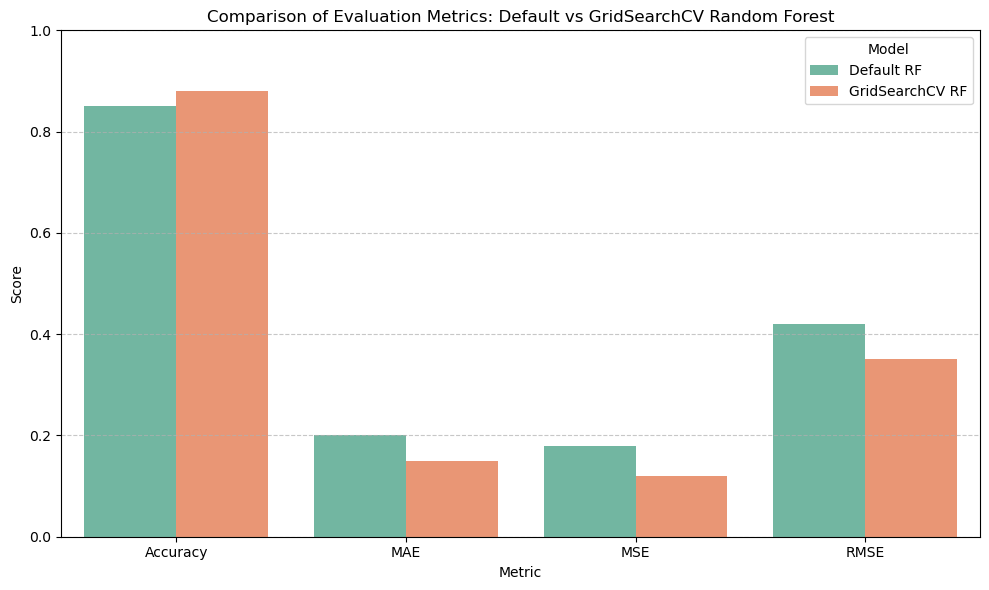

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
metrics = ['Accuracy', 'MAE', 'MSE', 'RMSE']
default_model_scores = [0.85, 0.20, 0.18, 0.42]  
gridsearch_model_scores = [0.88, 0.15, 0.12, 0.35]  
import pandas as pd
df_metrics = pd.DataFrame({
    'Metric': metrics * 2,
    'Score': default_model_scores + gridsearch_model_scores,
    'Model': ['Default RF'] * 4 + ['GridSearchCV RF'] * 4
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_metrics, palette='Set2')

plt.title('Comparison of Evaluation Metrics: Default vs GridSearchCV Random Forest')

plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
